In [11]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import wfdb
from scipy import signal
import urllib.request
import zipfile

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Set the working directory
os.chdir(r'C:\Users\kevxs\OneDrive\Documents\DATASCI 223\6-neural-nets-kxshi')

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_3', exist_ok=True)
os.makedirs('logs', exist_ok=True)
os.makedirs('data', exist_ok=True)

# Download MIT-BIH dataset
data_dir = 'data/mitdb'
if not os.path.exists(data_dir):
    print("Downloading MIT-BIH Arrhythmia Database...")
    url = "https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip"
    zip_path = 'data/mitdb.zip'
    
    # Download dataset
    urllib.request.urlretrieve(url, zip_path)
    
    # Extract dataset
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')
    
    # Clean up
    os.remove(zip_path)
    print("Dataset downloaded and extracted successfully.")

Dataset downloaded and extracted successfully.


Signal shape: (650000, 2)
Number of annotations: 2274
Unique beat types: ['+' 'A' 'N' 'V']


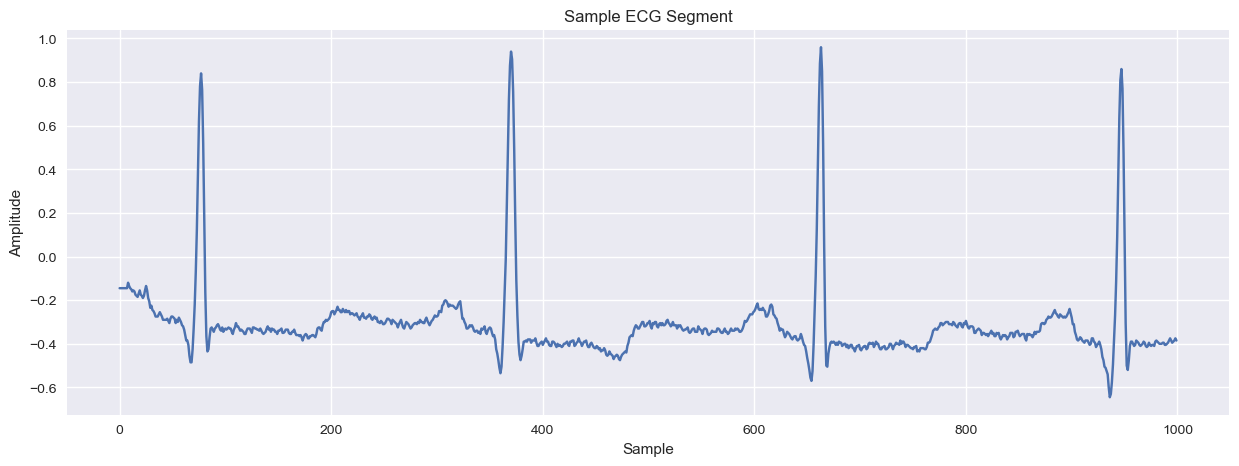

In [12]:
# Load ECG data
record_path = 'data/mit-bih-arrhythmia-database-1.0.0/100'  # Example record
record = wfdb.rdrecord(record_path)
signals = record.p_signal

# Read annotations
ann = wfdb.rdann(record_path, 'atr')
annotations = ann.symbol

# Print data information
print(f"Signal shape: {signals.shape}")
print(f"Number of annotations: {len(annotations)}")
print(f"Unique beat types: {np.unique(annotations)}")

# Plot sample ECG segment
plt.figure(figsize=(15, 5))
plt.plot(signals[:1000, 0])
plt.title('Sample ECG Segment')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

Data shape: (2273, 180, 2)
Label distribution: [2239   34]


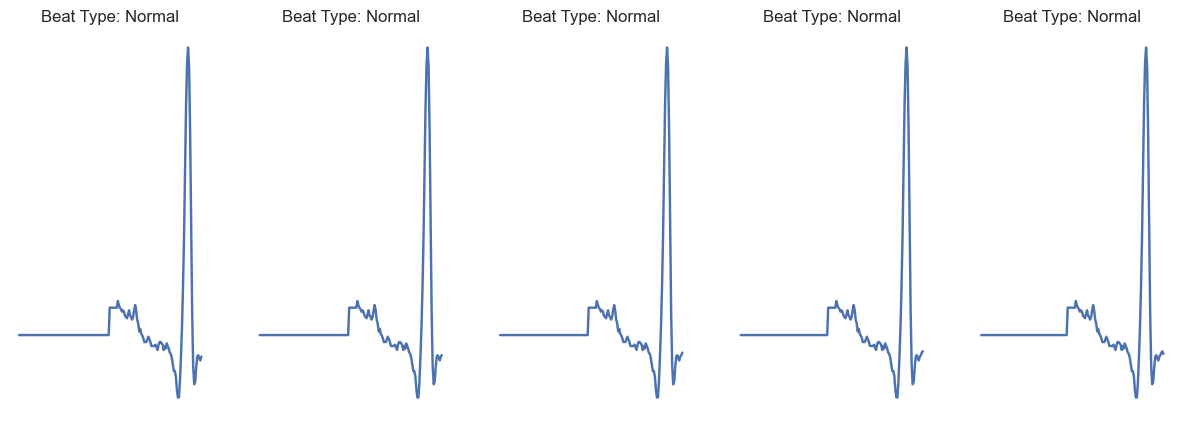

Class weights: {0: 0.5073272854152129, 1: 34.61904761904762}


In [25]:
# Preprocess ECG data
window_size = 180

# Normalize signals
signals = (signals - np.mean(signals)) / np.std(signals)

# Extract beats
X = []
y = []

for i, ann in enumerate(annotations):
    if ann in ['N', 'L', 'R', 'A', 'V']:  # Normal and abnormal beats
        # Get window around beat
        start = max(0, i - window_size//2)
        end = min(len(signals), i + window_size//2)
        
        # Pad if necessary
        if start == 0:
            pad_left = window_size//2 - i
            segment = np.pad(signals[start:end], ((pad_left, 0), (0, 0)))
        elif end == len(signals):
            pad_right = window_size//2 - (len(signals) - i)
            segment = np.pad(signals[start:end], ((0, pad_right), (0, 0)))
        else:
            segment = signals[start:end]
        
        X.append(segment)
        
        # Convert annotation to label
        if ann == 'N':
            y.append(0)  # Normal
        else:
            y.append(1)  # Abnormal

X = np.array(X)
y = np.array(y)

print(f"Data shape: {X.shape}")
print(f"Label distribution: {np.bincount(y)}")

# Plot sample beats
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.plot(X[i, :, 0])
    plt.title(f'Beat Type: {"Normal" if y[i] == 0 else "Abnormal"}')
    plt.axis('off')
plt.show()

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

print(f"Class weights: {class_weights}")

In [26]:
# Create simple neural network
def create_simple_nn(input_shape):
    """
    Create a simple neural network for ECG classification.
    
    Requirements:
    - Must use at least 2 dense layers
    - Must include dropout layers
    - Must use binary crossentropy loss
    - Must include AUC metric
    
    Goals:
    - Achieve > 75% accuracy on test set
    - Achieve AUC > 0.80
    - Achieve F1-score > 0.70
    - Minimize overfitting using dropout
    - Train efficiently with appropriate batch size
    
    Args:
        input_shape: Shape of input data (should be (180, 2) for ECG windows)
    
    Returns:
        Compiled Keras model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),

        # Convolution + Pooling
        tf.keras.layers.Conv1D(32, kernel_size=5, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(), # batch normalization
        tf.keras.layers.MaxPooling1D(pool_size=2),

        tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=2),

        tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling1D(),

        # Dense Layers
        tf.keras.layers.Dense(128, activation='relu'), # 1 - need 2 dense layers per function def
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')  # 2 
    ])

    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

    return model

# Create and compile model
model = create_simple_nn(input_shape=(180, 2))
model.summary()

c:\Users\kevxs\anaconda3\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 180, 32)        │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 180, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 90, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 90, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 90, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 45, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 45, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,897 (206.63 KB)

 Trainable params: 52,449 (204.88 KB)

 Non-trainable params: 448 (1.75 KB)

In [27]:
print(y_test[1:5])
unique_values, counts = np.unique(y_test, return_counts=True)

# Combine into a table-like output
count_table = dict(zip(unique_values, counts))
print(count_table)

[0 0 0 0]
{0: 444, 1: 11}


Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7798 - auc: 0.3463 - loss: 0.8907 - precision: 0.0016 - recall: 0.0313 - val_accuracy: 0.6456 - val_auc: 0.2023 - val_loss: 0.6894 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7164 - auc: 0.6001 - loss: 0.6928 - precision: 0.0229 - recall: 0.4145 - val_accuracy: 0.9725 - val_auc: 0.5877 - val_loss: 0.6398 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6272 - auc: 0.6090 - loss: 0.6712 - precision: 0.0186 - recall: 0.4508 - val_accuracy: 0.7390 - val_auc: 0.2348 - val_loss: 0.6681 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6526 - auc: 0.6843 - loss: 0.6359 - precision: 0.0296 - recall: 0.7046 - val_accuracy: 0.9396 - val_auc: 0.3750 - val_

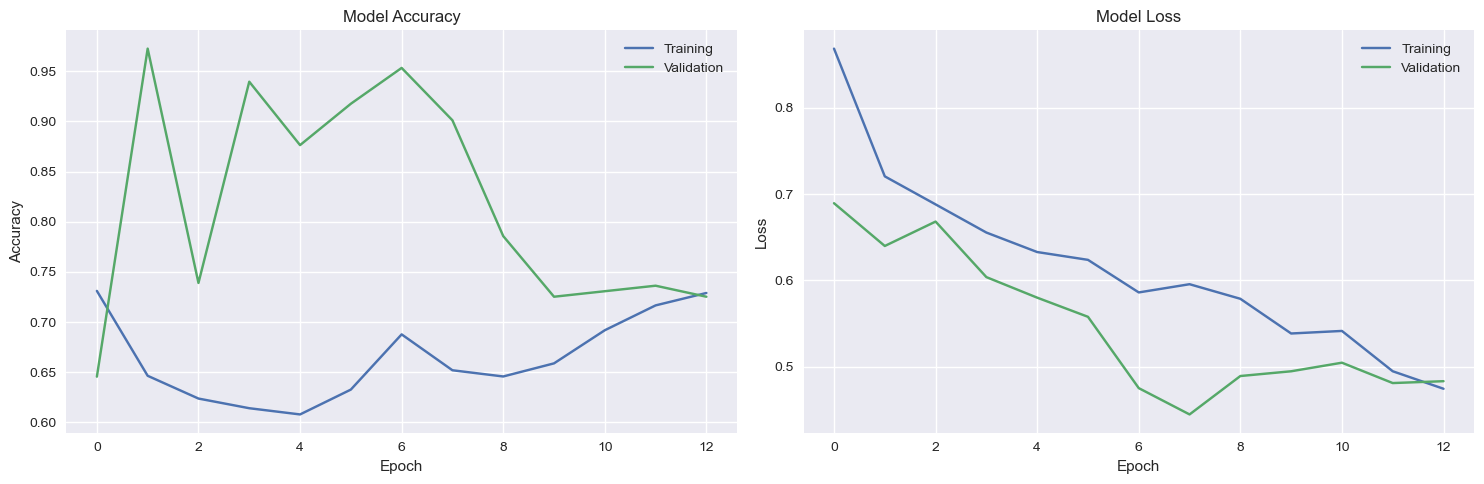

In [28]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/ecg_classifier.keras',
        save_best_only=True
    )
]

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weights  # Apply the weights here
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8416 - auc: 0.4708 - loss: 0.4897 - precision: 0.0082 - recall: 0.0352         
Test accuracy: 0.8681
Test AUC: 0.5816
Test Precision: 0.0196
Test Recall: 0.0909
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


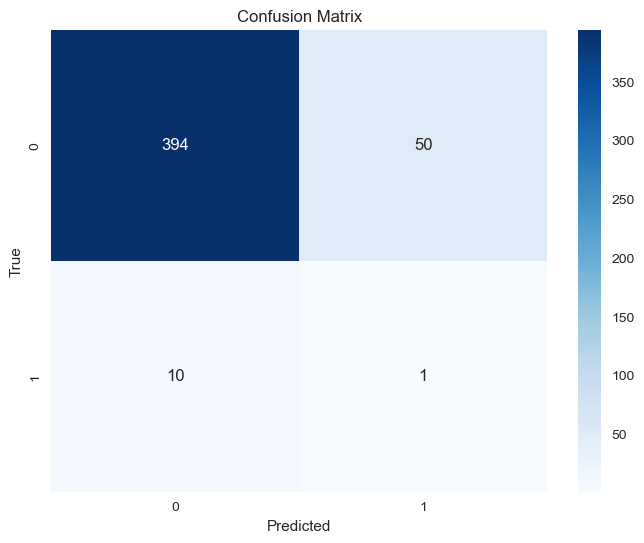

{'model': 'ecg_classifier', 'accuracy': 0.8681318759918213, 'auc': 0.5815929174423218, 'precision': 0.0196078431372549, 'recall': 0.09090909090909091, 'f1_score': 0.03225806451612903, 'confusion_matrix': [[394, 50], [10, 1]]}


In [30]:
# Evaluate model
test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Get predictions
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

# Calculate confusion matrix
cm = tf.math.confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate additional metrics
tn, fp, fn, tp = cm.numpy().ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

# Save metrics
metrics = {
    'model': 'ecg_classifier',
    'accuracy': float(test_accuracy),
    'auc': float(test_auc),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.numpy().tolist()
}

# Save to file
with open('results/part_3/ecg_classifier_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write(f"auc: {metrics['auc']}\n")
    f.write(f"precision: {metrics['precision']}\n")
    f.write(f"recall: {metrics['recall']}\n")
    f.write(f"f1_score: {metrics['f1_score']}\n")
    f.write(f"confusion_matrix: {metrics['confusion_matrix']}\n")
    f.write("----\n")

print(metrics)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


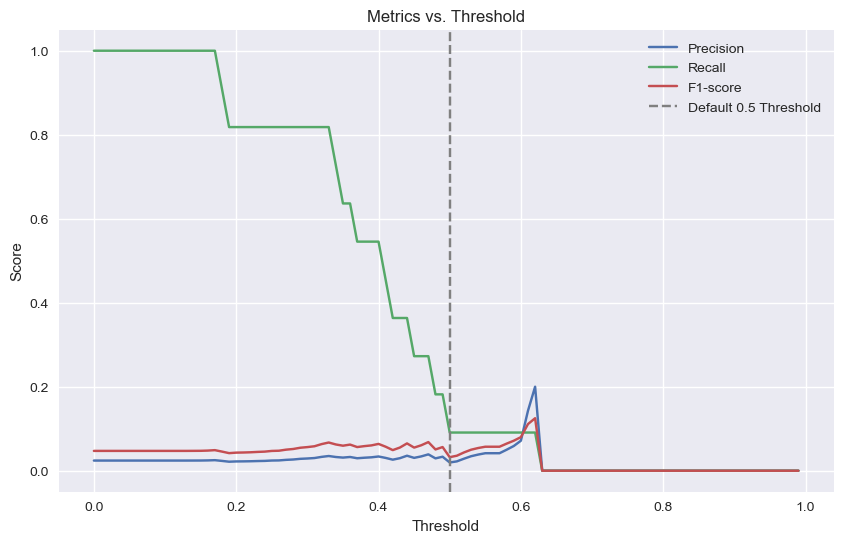

In [31]:
predictions = model.predict(X_test).flatten()  # Probabilities between 0 and 1

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

thresholds = np.arange(0.0, 1.0, 0.01)
precision_list = []
recall_list = []
f1_list = []

for thresh in thresholds:
    predicted_labels = (predictions >= thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predicted_labels, average='binary', zero_division=0)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_list, label='Precision')
plt.plot(thresholds, recall_list, label='Recall')
plt.plot(thresholds, f1_list, label='F1-score')
plt.axvline(0.5, color='gray', linestyle='--', label='Default 0.5 Threshold')
plt.title('Metrics vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
best_thresh = thresholds[np.argmax(f1_list)]
print(f"Best threshold based on F1-score: {best_thresh:.2f}")

Best threshold based on F1-score: 0.62


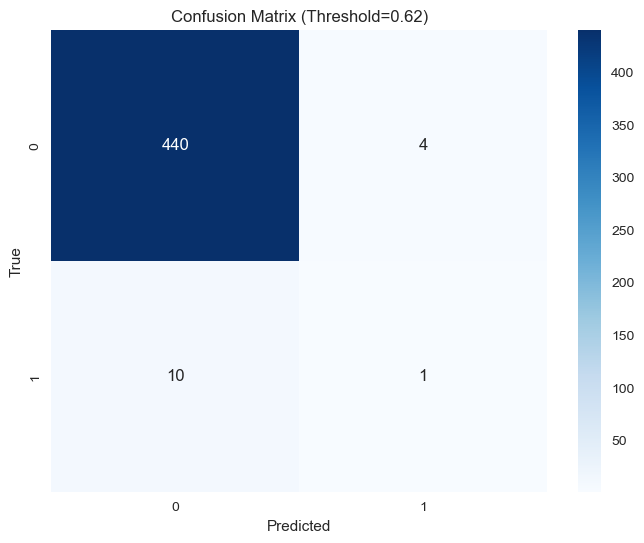

Accuracy:  0.9692
AUC:       0.5813
Precision: 0.2000
Recall:    0.0909
F1-score:  0.1250


In [41]:
# Find best threshold - highest f1 score
best_thresh = thresholds[np.argmax(f1_list)]

predicted_labels_best = (predictions >= 0.62).astype(int)

accuracy = accuracy_score(y_test, predicted_labels_best)
auc = roc_auc_score(y_test, predictions) 
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predicted_labels_best, average='binary', zero_division=0)

cm = tf.math.confusion_matrix(y_test, predicted_labels_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Threshold={best_thresh:.2f})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Step 7: Print metrics
print(f"Accuracy:  {accuracy:.4f}")
print(f"AUC:       {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")